#**ML PROJECT**


---
Authors:


*   Chiara Cavigliano
*   Virginia Tasso
*  Luca Zanotto






#**INTRODUCTION**


The purpose of the project is to create and evaluate a model able to predict the occurrence or absence of a flood based on initial conditions.

We possess a dataset of 3000 observations, each one detailing the initial and final states.
These observations illustrate the development of flooding in a hypothetical metropolitan plan as a function of infrastructure, elevation, and street connectivity.


*'edge_info.csv'* contains the geographic layout documentation, which includes street networks and position coordinates. The ' *'training_parameters.csv'* and *'test_parameters.csv'* files, respectively, contain information on the initial and changing parameters affecting flood dynamics.


#**Importing useful libraries**

In [ ]:
# import useful libraries
import pandas as pd
import numpy as np
import csv
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/MachineLearning/MLAssignment202324'
train_path = '/content/drive/MyDrive/MachineLearning/MLAssignment202324/training'
test_path = "/content/drive/MyDrive/MachineLearning/MLAssignment202324/test"
edges_info = pd.read_csv('/content/drive/MyDrive/MachineLearning/MLAssignment202324/edge_info.csv')
train_parameters = pd.read_csv('/content/drive/MyDrive/MachineLearning/MLAssignment202324/training_parameters.csv')
test_parameters = pd.read_csv('/content/drive/MyDrive/MachineLearning/MLAssignment202324/test_parameters.csv')
os.chdir(base_path)
!ls

 best_random_forest_model.pkl   example.csv		  test
 cache			        example.png		  test_parameters.csv
 edge_info.csv		        log.csv			  training
'Elevation Map.png'	        random_forest_model.pkl   training_parameters.csv


# **CREATION OF THE DATASET**
In this section we put together all the useful information from "train_parameters.csv", "edges_info.csv" and all the files contained in "/training" directory in order to have a complete dataset for training.

The dataset that we obtain contains 573000 rows (which correspond to the 3000 observations for each one of the 191 roads) and 14 columns; these columns include those present in the training files, in the edge info and in train parameteres.

In [ ]:
# #convert the edges coordinates

# edges_index = []
# for i in range(len(edges_info)):
#   edges_index.append(i)

# edges_info['Edges_index'] = edges_index
# edges_info.head()

,head_id,tail_id,longitude,latitude,altitude,Edges_index
0,151779659,153066427,-95.382821,29.798740,957.0,0
1,151779659,152426116,-95.383237,29.798445,921.2,1
2,151779659,152136099,-95.382354,29.797764,876.0,2
3,151779763,152437059,-95.380082,29.795224,897.0,3
4,151779763,152541741,-95.380394,29.796295,877.6,4


In [ ]:
os.chdir(train_path)
train_data = []
n = 0
for dir,_, files in os.walk(train_path):
  for file in sorted(files):
    if file.endswith('.csv'):
      filepath = os.path.join(dir, file)
      df = pd.read_csv(filepath)
      #print(filepath)
      n += 1
      obs_idx = int(file.split('.')[0])
      train_parameters_row = train_parameters.loc[obs_idx]
      # now i add to all the rows of the df (i.e. to all the roads) the corresponing training parameters
      # so to all the 191 rows of file '0.csv' i will add the columns with the training parameters
      # of observation 0
      for col in train_parameters_row.index:
        df[col] = train_parameters_row[col]

      # add the edges_info (alt, lat and long)
      df = pd.merge(edges_info, df, on = ['head_id', 'tail_id'], how = 'inner')

        #print(df.columns)
      #print(merged_df.columns)
      train_data.append(df)
print(n)

In [ ]:
final_train_data = pd.concat(train_data, ignore_index=True)
print(final_train_data.shape)

# **DATASET EXPLORATION**

To understand the distribution of every variable of the dataset we made some analysis both for the
categorical variables and for the numerical ones. To do this we created 2 different datasets, one with
the categorical variables only.




In [ ]:
# check if there are missing values in at least one column of the dataset
print(train_parameters.isna().any())
print(train_parameters.dtypes)
for column in final_train_data.columns:
    unique_values = final_train_data[column].unique()
    print(f'{column}: {unique_values}')
    print('-' * 30)

SurfaceType               False
RainfallIntensity         False
init_max_hour             False
DrainageSystemCapacity    False
GreenSpaceRatio           False
ObservationIndex          False
dtype: bool
SurfaceType                object
RainfallIntensity           int64
init_max_hour               int64
DrainageSystemCapacity    float64
GreenSpaceRatio           float64
ObservationIndex            int64
dtype: object
head_id: [ 151779659  151779763  152130254  152130257  152130265  152130268
  152130280  152136099  152136103  152136106  152136108  152136110
  152136112  152205779  152223474  152331933  152331936  152341226
  152341229  152361419  152361421  152361424  152426116  152432894
  152432898  152432902  152432904  152432906  152432908  152432914
  152432917  152432928  152432996  152432997  152432999  152433002
  152433006  152437059  152443826  152443827  152443829  152443831
  152443834  152454095  152541371  152541618  152541735  152541736
  152541738  152541741  152559392

From the previous cell we can notice that in RainFallIntensity there is as possible value '-999'. This is with strong probability a **missing value**, so we will remove it

In [ ]:
final_train_data = final_train_data[final_train_data['RainfallIntensity']!= -999]
print(final_train_data.shape)
print(type(final_train_data))
final_train_data.head()

(572236, 14)
<class 'pandas.core.frame.DataFrame'>


,head_id,tail_id,longitude,latitude,altitude,Edges_index,flooded_init,flooded_final,SurfaceType,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex
0,151779659,153066427,-95.382821,29.798740,957.0,0,False,False,D,5,3,0.11,0.11,0
1,151779659,152426116,-95.383237,29.798445,921.2,1,False,False,D,5,3,0.11,0.11,0
2,151779659,152136099,-95.382354,29.797764,876.0,2,False,False,D,5,3,0.11,0.11,0
3,151779763,152437059,-95.380082,29.795224,897.0,3,False,False,D,5,3,0.11,0.11,0
4,151779763,152541741,-95.380394,29.796295,877.6,4,False,False,D,5,3,0.11,0.11,0


#**Label Encoding**

Label Encoding is a technique used to represent categorical variables with numerical values. It assigns a unique integer to each category in a categorical variable.
Since lots of machine learning algorithm require numerical input. Label Encoding provides a simple way to convert categorical data into a format that these algorithms can work with.

In [ ]:
# Convert SurfaceType into [0, 1, 2, 3]
label_encoder = LabelEncoder()
final_train_data['SurfaceType_cat'] = label_encoder.fit_transform(final_train_data['SurfaceType'])
print('Original Classes: ', label_encoder.classes_)
print('Final Classes: ', final_train_data['SurfaceType_cat'].unique())

# remove the original SurfaceType Columns and keep only the one encoded
final_train_data.drop(['SurfaceType'], axis=1, inplace=True)


# Transform "Flooded_final" and "Flooded_init" into 0 and 1
# Convert SurfaceType into categorical variable
label_encoder = LabelEncoder()
final_train_data['FloodedFinal'] = label_encoder.fit_transform(final_train_data['flooded_final'])
print('Original Classes: ', label_encoder.classes_)
print('Final Classes: ', final_train_data['FloodedFinal'].unique())


final_train_data['FloodedInit'] = label_encoder.fit_transform(final_train_data['flooded_init'])
print('Original Classes: ', label_encoder.classes_)
print('Final Classes: ', final_train_data['FloodedInit'].unique())


#drop of the old columns
final_train_data.drop(['flooded_final', 'flooded_init'], axis = 1, inplace = True)

final_train_data.head()

Original Classes:  ['A' 'B' 'C' 'D']
Final Classes:  [3 1 0 2]
Original Classes:  [False  True]
Final Classes:  [0 1]
Original Classes:  [False  True]
Final Classes:  [0 1]


<ipython-input-51-4556460f9a50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data['SurfaceType_cat'] = label_encoder.fit_transform(final_train_data['SurfaceType'])


,head_id,tail_id,longitude,latitude,altitude,Edges_index,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex,SurfaceType_cat,FloodedFinal,FloodedInit
0,151779659,153066427,-95.382821,29.798740,957.0,0,5,3,0.11,0.11,0,3,0,0
1,151779659,152426116,-95.383237,29.798445,921.2,1,5,3,0.11,0.11,0,3,0,0
2,151779659,152136099,-95.382354,29.797764,876.0,2,5,3,0.11,0.11,0,3,0,0
3,151779763,152437059,-95.380082,29.795224,897.0,3,5,3,0.11,0.11,0,3,0,0
4,151779763,152541741,-95.380394,29.796295,877.6,4,5,3,0.11,0.11,0,3,0,0


In [ ]:
final_train_data.head()

,head_id,tail_id,longitude,latitude,altitude,Edges_index,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex,SurfaceType_cat,FloodedFinal,FloodedInit
0,151779659,153066427,-95.382821,29.798740,957.0,0,5,3,0.11,0.11,0,3,0,0
1,151779659,152426116,-95.383237,29.798445,921.2,1,5,3,0.11,0.11,0,3,0,0
2,151779659,152136099,-95.382354,29.797764,876.0,2,5,3,0.11,0.11,0,3,0,0
3,151779763,152437059,-95.380082,29.795224,897.0,3,5,3,0.11,0.11,0,3,0,0
4,151779763,152541741,-95.380394,29.796295,877.6,4,5,3,0.11,0.11,0,3,0,0


Separation of categotical and numerical variables

In [ ]:
cat_data = final_train_data[["RainfallIntensity", "init_max_hour", "SurfaceType_cat", "FloodedInit", "FloodedFinal"]]
num_data = final_train_data[["DrainageSystemCapacity", "GreenSpaceRatio", "latitude", "altitude", "longitude"]]


#**Categorical Variables exploration**
We analyzed the four categorical variables 'RainfallIntensity', 'init_max_hour', 'SurfaceType_cat' and 'FloodedInit' by plotting their histograms and putting them in comparison with our target variable, 'FloodedFinal'.



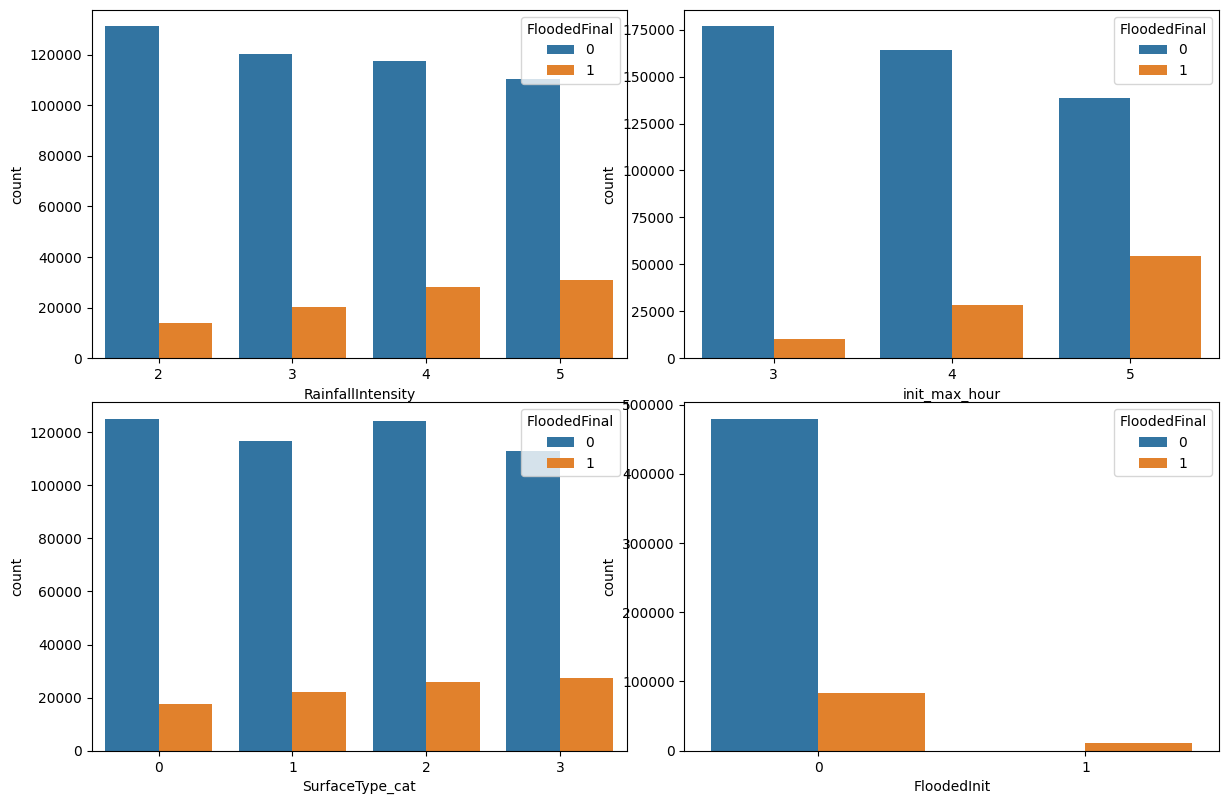

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (12,8))
axes = axes.flatten()
fig.tight_layout()
i = 0
for col in cat_data.columns[:-1]:
  sns.countplot(x = col, hue = 'FloodedFinal', ax = axes[i], data = cat_data)
  i += 1
#plt.tight_layout()
plt.show()

#**Numerical variables exploration**
In order to visualize the distribution of the numerical variables we plotted the histogram of each of
them.

<ipython-input-79-e8ef48f8da10>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
<ipython-input-79-e8ef48f8da10>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
<ipython-input-79-e8ef48f8da10>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
<ipython-input-79-e8ef48f8da10>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4 = plt.

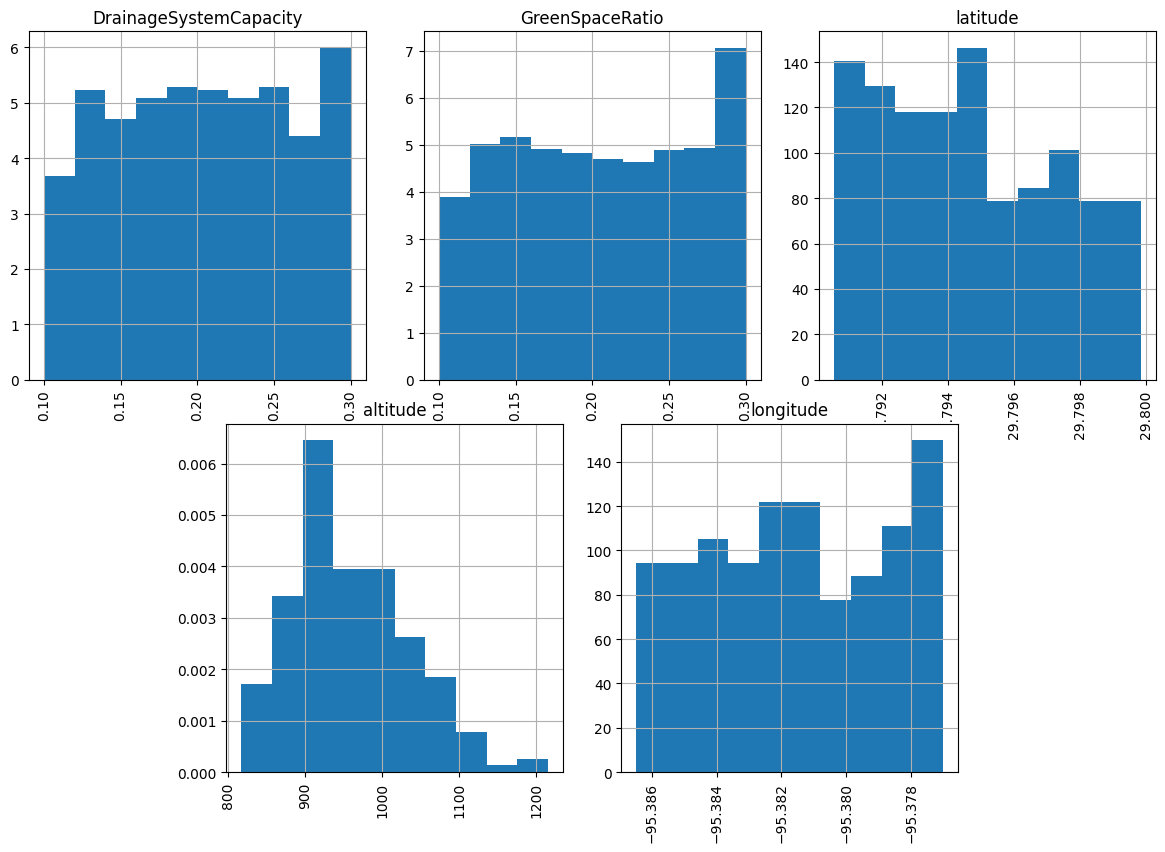

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (12,8))
axes = axes.flatten()

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.tight_layout()
axes_to_plot = [ax1, ax2,ax3,ax4,ax5]
i = 0
for  col in num_data.columns:
  plt.sca(axes_to_plot[i])
  plt.hist(num_data[col], density = True)
  plt.xticks(rotation = 90)
  plt.grid(True)
  plt.title(col)
  i += 1
plt.show()

#**STATISTICAL ANALYSIS OF DATA**
After dataset exploration, we carried out statistical analysis to identify possible relationships between the variables of the dataset

#**Chi square test and Cramer's Coefficient**
The **chi-square test** is often used to determine whether there is a significant association between the variables based on the observed and expected frequencies within a contingency table. The test helps in understanding the degree of association or independence between the variables.
Together with the chi-square test is extremely important to observe its associated p-value, in order to evaluate the statistical significance of the test.

If the associated chi-square test returns a p-value below the chosen significance level (usually $p-value < 0.05$), you may conclude that this association is statistically significant.

The formula for chi-square is
$$\chi^2 = \sum \frac{(O_{ij} - E_{ij})^2}{E_{ij}}$$

An effect size measurement for the chi-square test of indipendence is the **Cramer's V coefficient**. This coefficient can range from 0 to 1 and provides a measure of the strength of the association between categorical variables.
A value close to 1 indicates a strong association between the variables.
A value of 0 indicates no association between the variables.

The formula for Cramer's V is

$$
V = \sqrt{\frac{\chi^2}{n \cdot (\min(R, C) - 1)}}
$$


<ipython-input-56-ffd344d51adc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data_cat.RainfallIntensity = final_train_data_cat['RainfallIntensity'].astype(int)


[5 3 4 2]
Variable:  RainfallIntensity
chi2: 9158.714690125405
p-value:             0.000000
Cramers value: 0.126511
Variable:  init_max_hour
chi2: 37173.827921637945
p-value:             0.000000
Cramers value: 0.254877
Variable:  SurfaceType_cat
chi2: 2840.4515242557536
p-value:             0.000000
Cramers value: 0.070454
Variable:  FloodedInit
chi2: 53969.47224818714
p-value:             0.000000
Cramers value: 0.307105
Variable:  FloodedFinal
chi2: 572228.6468981092
p-value:             0.000000
Cramers value: 0.999994


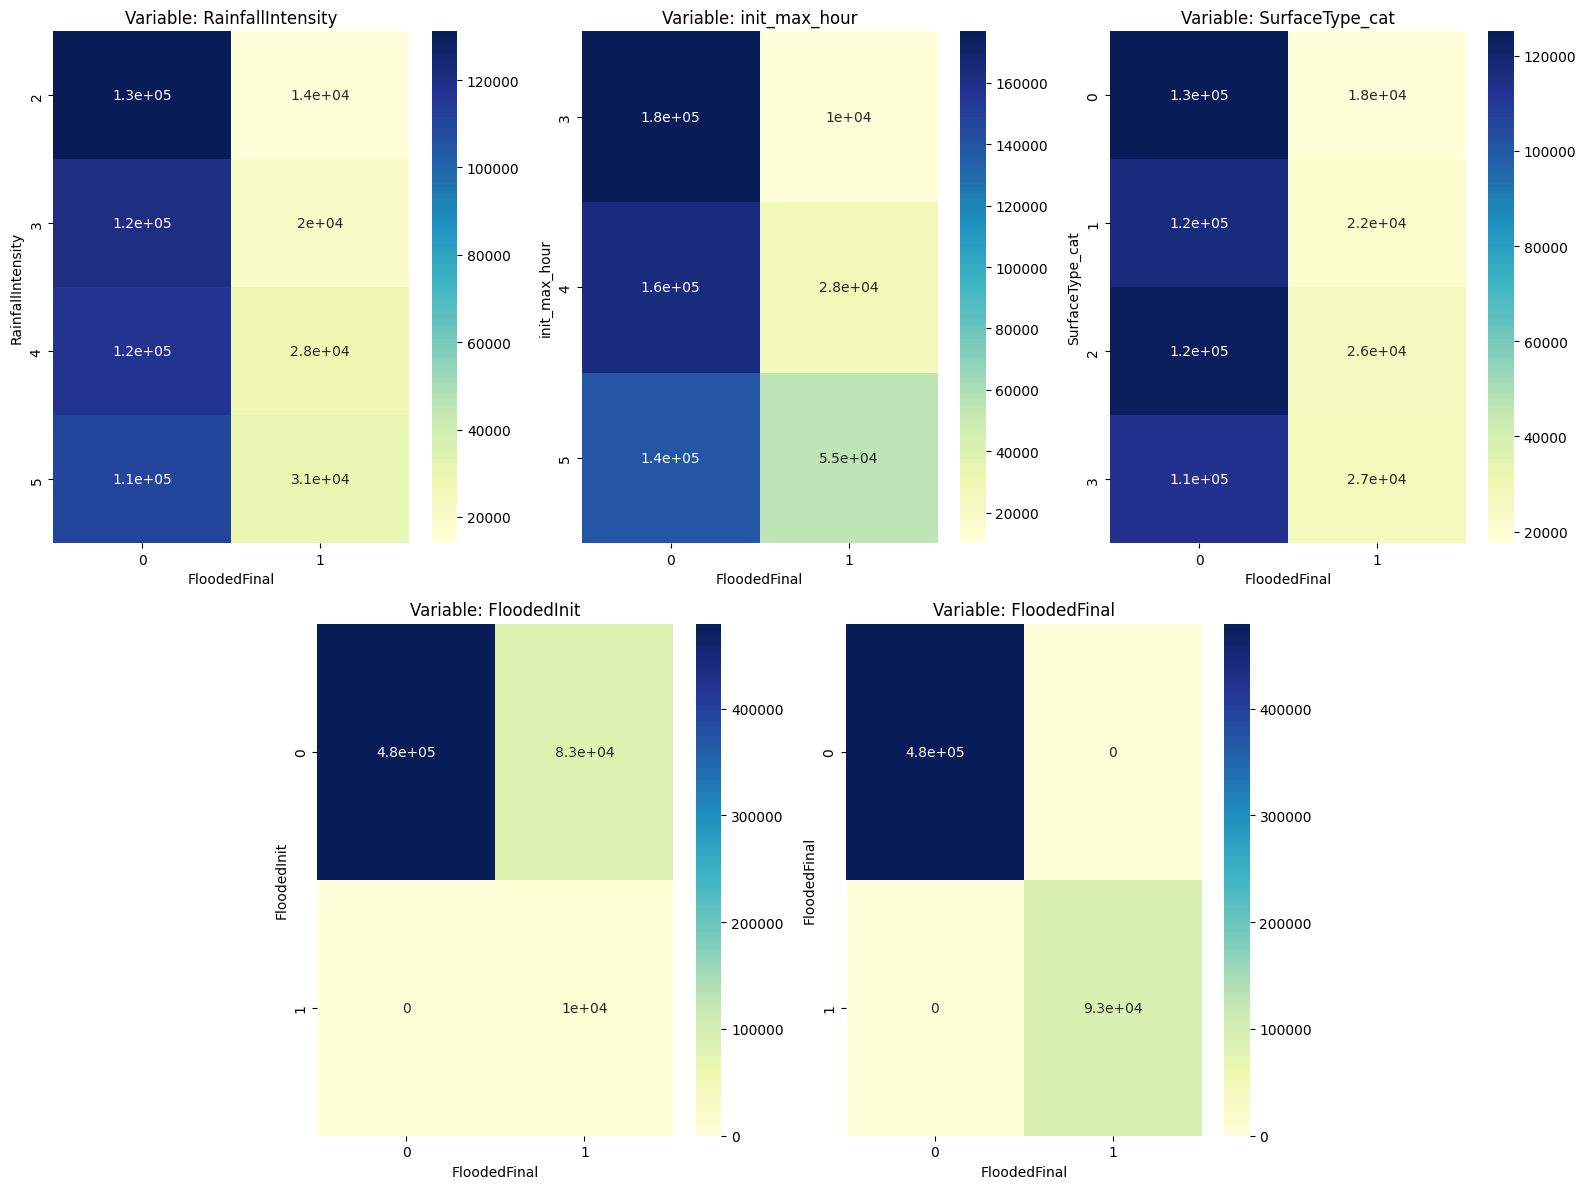

In [ ]:
final_train_data_cat = final_train_data[['RainfallIntensity', 'init_max_hour', 'SurfaceType_cat', 'FloodedInit', 'FloodedFinal']]
final_train_data_cat.RainfallIntensity = final_train_data_cat['RainfallIntensity'].astype(int)
final_train_data.RainfallIntensity = final_train_data.RainfallIntensity.astype(int)
cat_vars = final_train_data_cat[:-1]
print(cat_vars.RainfallIntensity.unique())
contingency_tables = {}


for col in final_train_data_cat:
  contingency_table = pd.crosstab(index = final_train_data_cat[col], columns = final_train_data_cat['FloodedFinal'])
  contingency_tables[col] = contingency_table

# Computation of CHI 2 and Cramer's Coefficient
chi2_res_and_cramer = {}
for col, table in contingency_tables.items():
  chi2, p_value, _,_ = chi2_contingency(table)
  n = table.sum().sum()  # Total number of observations
  #cramers_v_value = np.sqrt(chi2 / (n * (min(table.shape) - 1)))
  cramers_v_value = np.sqrt(chi2 / n)
  chi2_res_and_cramer[col] = {'chi2': chi2, 'p-value': p_value, 'cramer':cramers_v_value}

for col, res in chi2_res_and_cramer.items():
  print(f"Variable:  {col}")
  print(f"chi2: {res['chi2']}")
  print(f"p-value: {res['p-value']:20f}")
  print(f'Cramers value: {res["cramer"]:5f}')
  print("="*40)


# plot contingency tables
fig = plt.figure(figsize = (16, 12))
gs = gridspec.GridSpec(2,3, width_ratios = [1,1,1])
plt.tight_layout()
axes = [
    plt.subplot2grid((2, 6), (0, 0), colspan=2),
    plt.subplot2grid((2, 6), (0, 2), colspan=2),
    plt.subplot2grid((2, 6), (0, 4), colspan=2),
    plt.subplot2grid((2, 6), (1, 1), colspan=2),
    plt.subplot2grid((2, 6), (1, 3), colspan=2)
]
for i, (col, table) in enumerate(contingency_tables.items()):
  ax = axes[i]
  sns.heatmap(table, annot = True, cmap = 'YlGnBu', ax = ax)
  ax.set_title(f"Variable: {col}")
plt.tight_layout()
plt.show()


#**The Spearmanr's coefficient**

The **Spearmanr's coefficient** is a measure of statistical dependence between two variables. It assesses how well the relationship between the variables can be described using a monotonic function.

The spearman's coefficient varies between -1 and 1 and measures the relationship between two variables.
The Spearman correlation coefficient is particularly useful when the assumptions of the Pearson correlation coefficient are not met, such as when the relationship between variables is not linear or when the data is not normally distributed.
 Since, as demonstrated above, we have non-normally distributed data, we decide to use this coefficient to determine the relationship between the target variable 'FloodedFinal' and the numerical explanatory variables


- 1: Indicates a perfectly monotonic positive correlation, i.e. both variables increase together.

- 0: Indicates no monotonic relationship between the variables.
- -1: Indicates a perfectly monotonic negative correlation, i.e. one variable decreases while the other one increases.
A low p-value suggests that the observed monotonic relationship is unlikely to be due to chance --> the relationship dictated by the coefficient has statistical significance.
Spearman coefficient is calculated using the following formula:

$$
\rho = 1 - \frac{6 \sum d_i^2}{n(n^2 - 1)}
$$

- $d_i$ = difference in the ranks of the $i^{th}$ observation
- n = number of observations
- $\rho$ = Spearmanr rank's correlation coefficient

In [ ]:
spear_res = {}
for col in num_data.columns:
  corr, p_value = spearmanr(final_train_data['FloodedFinal'],final_train_data[col])
  spear_res[col] = {'correlation': corr, 'p-value': p_value}

for col, res in spear_res.items():
  print(f"Variable: {col}")
  print(f"Spearsman's coefficient: {res['correlation']:4f}")
  print(f"P-Value: {res['p-value']:4f}")
  print("="*30)


Variable: DrainageSystemCapacity
Spearsman's coefficient: -0.140117
P-Value: 0.000000
Variable: GreenSpaceRatio
Spearsman's coefficient: -0.001471
P-Value: 0.265743
Variable: latitude
Spearsman's coefficient: -0.002784
P-Value: 0.035205
Variable: altitude
Spearsman's coefficient: -0.003751
P-Value: 0.004546
Variable: longitude
Spearsman's coefficient: -0.004467
P-Value: 0.000727


We can see that variables that are related with the target variable FloodedFinal are:

*   RainfallIntensity
*   init_max_hour
*DrainageSystemCapacity
*FloodedInit





To have a deeper understanding of relationships between categorical variables, we also employed contintency tables.

A **contingency table** is a table that displays the frequency distribution of two categorical variables. Each cell in the table represents the count of frequency of observations that fall into a particular combination of categories for the two variables.

The table is organized into rows and columns, with each row corresponding to one category of the first variable and each column corresponding to one category of the second variable. The intersections of rows and column contain the counts or frequencies of observations that share a specific combination of the two categorical variables.

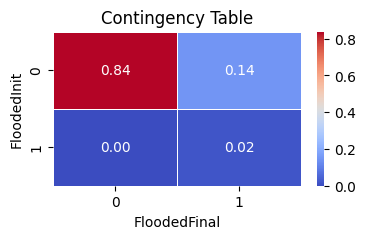

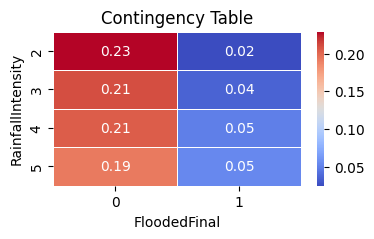

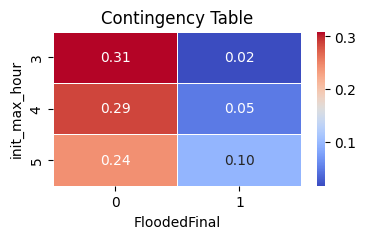

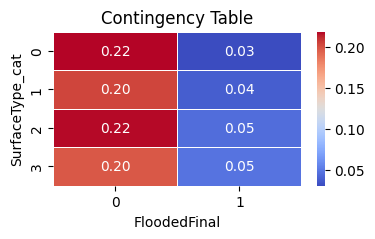

In [ ]:
#Contingency table
final_train_data_cat = final_train_data[['RainfallIntensity', 'init_max_hour', 'SurfaceType_cat', 'FloodedFinal', 'FloodedInit']]

contingency_table = pd.crosstab(final_train_data_cat['FloodedInit'], final_train_data_cat['FloodedFinal'])
contingency_table_percent = contingency_table.div(572236)
plt.figure(figsize=(4,2))
sns.heatmap(contingency_table_percent, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Contingency Table')
plt.show()

contingency_table = pd.crosstab(final_train_data_cat['RainfallIntensity'], final_train_data_cat['FloodedFinal'])
contingency_table_percent = contingency_table.div(572236)
plt.figure(figsize=(4,2))
sns.heatmap(contingency_table_percent, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Contingency Table')
plt.show()

contingency_table = pd.crosstab(final_train_data_cat['init_max_hour'], final_train_data_cat['FloodedFinal'])
contingency_table_percent = contingency_table.div(572236)
plt.figure(figsize=(4,2))
sns.heatmap(contingency_table_percent, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Contingency Table')
plt.show()

contingency_table = pd.crosstab(final_train_data_cat['SurfaceType_cat'], final_train_data_cat['FloodedFinal'])
contingency_table_percent = contingency_table.div(572236)
plt.figure(figsize=(4,2))
sns.heatmap(contingency_table_percent, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Contingency Table')
plt.show()

After the various analysis between variables we can conclude that  while we haven't identified exceptionally strong correlations with FloodedFinal, certain variables still emerge as relevant to be considered for our training dataset. These variables include:

- Drainage system capacity-> negatively correlated with FloodedFinal
- RainfallIntensity-> positively correlated with FloodedFinal
- FloodedInit-> positively correlated with FloodedFinal
- init max hours (Initial Water levels)-> positively correlated with FloodedFinal


In the end, we obtain a dataset with 6 columns and 572236 rows
**ASPE QUI DEVO SISTEMARE**

In [ ]:
#final_train_data = final_train_data[['SurfaceType_cat', 'RainfallIntensity', 'init_max_hour', 'DrainageSystemCapacity', 'FloodedInit', 'FloodedFinal']] Questo abbiamo deciso di farlo con la pca
print(final_train_data.shape)
print(final_train_data.head())
print(final_train_data['DrainageSystemCapacity'].unique())
print(final_train_data['init_max_hour'].unique())

(572236, 14)
     head_id    tail_id  longitude   latitude  altitude  Edges_index  \
0  151779659  153066427 -95.382821  29.798740     957.0            0   
1  151779659  152426116 -95.383237  29.798445     921.2            1   
2  151779659  152136099 -95.382354  29.797764     876.0            2   
3  151779763  152437059 -95.380082  29.795224     897.0            3   
4  151779763  152541741 -95.380394  29.796295     877.6            4   

   RainfallIntensity  init_max_hour  DrainageSystemCapacity  GreenSpaceRatio  \
0                  5              3                    0.11             0.11   
1                  5              3                    0.11             0.11   
2                  5              3                    0.11             0.11   
3                  5              3                    0.11             0.11   
4                  5              3                    0.11             0.11   

   ObservationIndex  SurfaceType_cat  FloodedFinal  FloodedInit  
0      

The analysis of the dataset reveals a strong imbalance in the distribution of the targets, 0 and 1.

Infact instances with a value of 1 are  underrepresented compared to instances with a value of 0. Class imbalance can affect the performance of machine learning models, especially those designed to predict rare events or minority classes.

To address this imbalance, we will perform an oversampling of data during the training phase.

This procedure will help us to expose the machine learning model to a more balanced distribution of both classes.

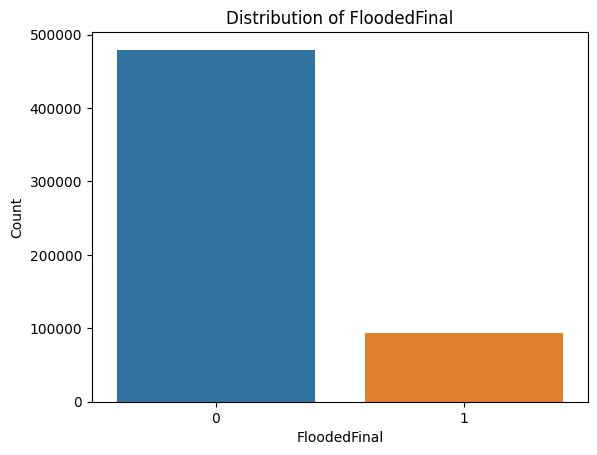

In [ ]:
# check how FloodedFinal variable is distributed
sns.countplot(data = final_train_data, x= 'FloodedFinal')
plt.title('Distribution of FloodedFinal')
plt.ylabel('Count')
plt.show()

# **Standardization**
Most learning models benefit from a preventive standardization of the data, also colled normalization. The most popular techniques are:
- Decimal Scaling
- Z-score
- Min-Max normalization

We opted for the last one.

Min-max standardization is achieved though the transformation:

$$x_{ij} = \frac{x_{ij} - x_{\text{min},j}}{x_{\text{max},j} - x_{\text{min},j}} \cdot (x'_{\text{max},j} - x'_{\text{min}, j}) + x'_{\text{min}, j}$$

We did not normalize categorical variables

In [ ]:
#standardization of continuous variables
scaler = MinMaxScaler(feature_range=(-1, 1))
final_train_data[['longitude', 'latitude', 'altitude', "DrainageSystemCapacity", "GreenSpaceRatio"]] = scaler.fit_transform(final_train_data[['longitude', 'latitude', 'altitude', "DrainageSystemCapacity", "GreenSpaceRatio"]])
final_train_data['DrainageSystemCapacity'] = final_train_data['DrainageSystemCapacity']
final_train_data['GreenSpaceRatio'] = final_train_data['GreenSpaceRatio']

#**PCA**
In order to reduce the number of attributes without losing any information, PCA was applied.
**Principal Components Analysis** is a linear dimensionality reduction technique that consists in transforming the data onto a new coordinate system, known as principal components, which are orthogonal and capture the maximum variance in the data.
 PCA is widely used for  dimensionality reduction by projecting high-dimensional data onto a lower-dimensional space while retaining most of the important information.


---
It can be seen from the graph that the first 5 components explain most of the variance (80%) of the dataset


[0.26788581 0.26484762 0.14191783 0.08357379 0.07447249 0.06969006
 0.06304443 0.03080663 0.00376134]


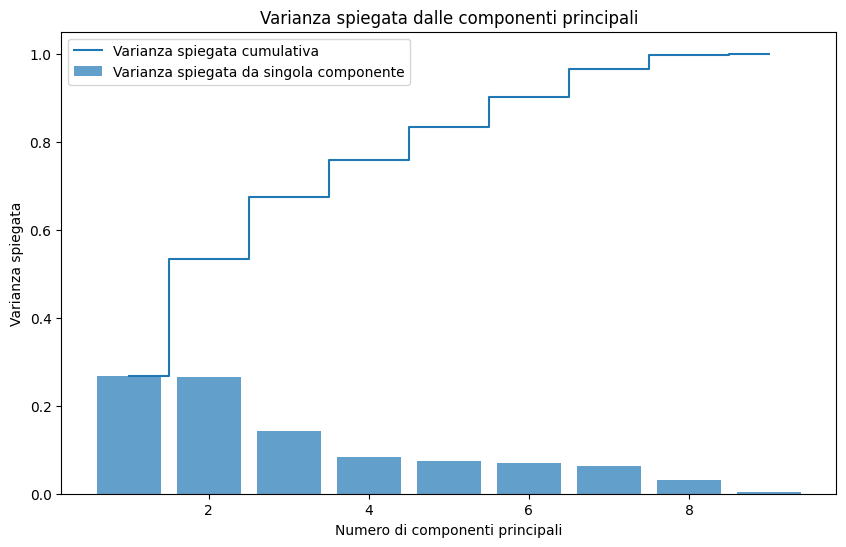

In [ ]:
# evaluation of principal components using PCA
pca_df = final_train_data.drop(['head_id', 'tail_id', 'Edges_index', 'ObservationIndex', 'FloodedFinal'], axis = 1)
pca = PCA()
principal_components = pca.fit_transform(pca_df)
explained_variance_ratio = pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)

#graphical representation
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Varianza spiegata da singola componente')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Varianza spiegata cumulativa')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata')
plt.title('Varianza spiegata dalle componenti principali')
plt.legend()
plt.show()



In [ ]:
pca = PCA(n_components = 7)
principal_components = pca.fit_transform(pca_df)
pca_expl_train = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7'])
print(len(pca_expl_train))
pca_expl_train.head()

572236


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.186421,-1.773537,1.039603,0.751515,0.895611,-0.841604,-0.529140
1,1.186421,-1.773537,1.039603,0.792160,0.895611,-0.841604,-0.405957
2,1.186421,-1.773537,1.039603,0.566812,0.895611,-0.841604,-0.376377
3,1.186420,-1.773536,1.039603,-0.151065,0.895611,-0.841603,-0.243568
4,1.186421,-1.773536,1.039603,0.045878,0.895611,-0.841603,-0.375500


In [ ]:
#SPLIT CON PCA
target_var = final_train_data['FloodedFinal']

from sklearn.model_selection import train_test_split
#SPLIT DATA INTO TRAIN AND TEST SET
expl_train, expl_test, target_train, target_test = train_test_split(pca_expl_train, target_var,
                                                    test_size =0.20, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify= target_var, #we use stratify as the target variable is unbalanced
                                                    random_state= 23
                                                   ) #fix random seed for replicability

#**Upsampling**


In response to the significant class imbalance observed in the distribution in the target variable, we opted for an upsampling strategy specifically targeting instances where FloodedFinal equals 1.

Upsampling has been implemented through the **RandomOverSampler** class provided by the **imbalanced-learn** library in Python.
Random over-sampling is a technique used to address class imbalance in machine learning. The RandomOverSampler class  can be used to over-sample the minority class by picking samples at random with replacement. This technique involves generating new samples in the under-represented class by duplicating existing samples. The RandomOverSampler class allows the control of the sampling strategy and the random state for reproducibility.

Before performed upsampling only on training data since it is extrenly important to not modify and perform data augmentation on test data

In [ ]:
#split the explanatory data and the target variable
expl_data = final_train_data[['RainfallIntensity', 'init_max_hour', 'DrainageSystemCapacity', 'SurfaceType_cat', 'FloodedInit']]
target_var = final_train_data[['FloodedFinal']]


#SPLIT DATA INTO TRAIN AND TEST SET
expl_train, expl_test, target_train, target_test = train_test_split(expl_data, target_var,
                                                    test_size =0.20, #by default is 75%-25%
                                                    #shuffle is set True by default,
                                                    stratify= target_var, #we use stratify as the target variable is unbalanced
                                                    random_state= 1
                                                   ) #fix random seed for replicability


#reset degli indici
expl_train.reset_index(drop=True, inplace=True)
expl_test.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
target_test.reset_index(drop=True, inplace=True)

In [ ]:


total_train = pd.concat([expl_train, target_train], axis = 1)
unique_counts = np.unique(total_train['FloodedFinal'], return_counts=True)
print('Before Upsampling',dict(zip(unique_counts[0], unique_counts[1])))
print('='*40)


oversample = RandomOverSampler(sampling_strategy=0.7, random_state=42)
expl_train_up, target_train_up = oversample.fit_resample(expl_train, target_train)
unique_counts = np.unique(target_train_up, return_counts=True)
print("After Upsampling", dict(zip(unique_counts[0], unique_counts[1])))

Before Upsampling {0.0: 383463, 1.0: 74325, nan: 78075}
After Upsampling {0: 383463, 1: 268424}


# **TRAINING MODELS**

To perform our prediction we tried different models and evaluated them according to different metrics, in order to understand which one could be the optimal. Specifically above all the available machine learning models, we tried those that are particularly suitable in handling unbalanced datasets.

- **Logistic Regression Classifier:** for binary classification. It is simple to implement, interpretable and can provide class membership probabilities.
-**Random Forest Classifier**: ensemble learning method used for classification, regression and other tasks. This method is effective in reducing overfitting and handling high-dimensional data with large numbers of features
- **Multi-Layer Perceptron Classifier** (also known as 'Neural Network'): it is a type of feed forward neural network. It is composed of multiple layers of interconnected nodes.
With the right training, it can handle a wide variety of input data and generalise to new data with ease. Its ability to replicate nonlinear interactions makes it a desirable option for a variety of machine learning applications, and its scalability enables improved performance on complex tasks by adding layers.
- **Adaboost Classifier:** ensemple learning method used for classification and regression tasks. It combines multiple weak classifiers to build one strong classifier. It is relatively easy to use and requires less parameter tuning compared to other algorithms like SVM.
- **Gradient Boosting Classifier:** ensemble method that combines the predictions from several base estimators, typically decision trees, to improve the accuracy and robustness of the model. It can be adapted to the non-linear setting, which can help mitigate issues related to imbalanced data
- **Support Vector Machine (SVM):** it can be used for both regression and classification tasks. It tries to find an hyperplane in a N-dimensional space able to distinclty classify the data points, i.e. it tries to find the hyperplane that has the maximum distance between datapoints of both classes.


#**PERFORMANCE METRICS**
Regarding the perfomance metrics we used:
- **Accuracy:** number of correct prediction over the total  number of predictions. We did not give great considerations to accuracy, since it is not robust in the face of imbalanced datasets and may incorrectly indicate good classifier performance.
- **Balanced Accuracy:** is a metric for evaluating classification model performance, especially in imbalanced datasets. It is the average of sensitivity (true positive rate) and specificity (true negative rate). This score is valuable in imbalanced class scenarios, offering a more accurate performance representation than standard accuracy.
- **Precision:** $$\frac{TP}{TP+FP}$$ it is tthe proportion of true positive predictions out of all positive predictions.
- **Recall**: $$\frac{TP}{TP+FN}$$  it measures the proportion of true positive predictions out of all actual positive instances.

Precision and Recall are particularly useful when dealing with imbalanced datasets, where the class of interest is in the minority, since they provide insights into the model's ability to make accurate positive predictions and to capture all positive instances, respectively.
It is important to consider both precision and recall together, as often improving one may lead to a decrease in the other.

- **F1-score:** $$F1 = 2 \times \frac{precision \times recall}{precision + recall}$$It is calculated as the harmonic mean of precision and recall, thus making it a particularly significant metric, useful for imbalanced datasets

- **AUC-ROC score (Area Under the Receiver Operationg Characteristic Curve):** metric used to evaluate the performance of a binary classification model and illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specifivity) as the classification threshold varies



Finally, we chose the **Random Forset classifier** since it is the one that reached the best results in terms of F1-score, precision, recall and AUC-ROC.
Specifically, the best results were obtained choosing 7 PCA components and an upsamping of 0.7.
The upsampling strategy corresponds to the desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling.


In [ ]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# useful for the compilation of the csv file to store performance metrics
fieldnames = ['f1-score', 'accuracy', 'recall','precision', 'balanced accuracy', 'auc-roc score']

#**Random Forest Classifier**


***RESULTS ON TEST SET***
F1_score:  0.7262060656854016
Accuracy 0.9086572067663917
Recall 0.7461385286044885
Precision:  0.707310851487169
0.843147601999262
AUC-ROC Score: 0.9486550773072753



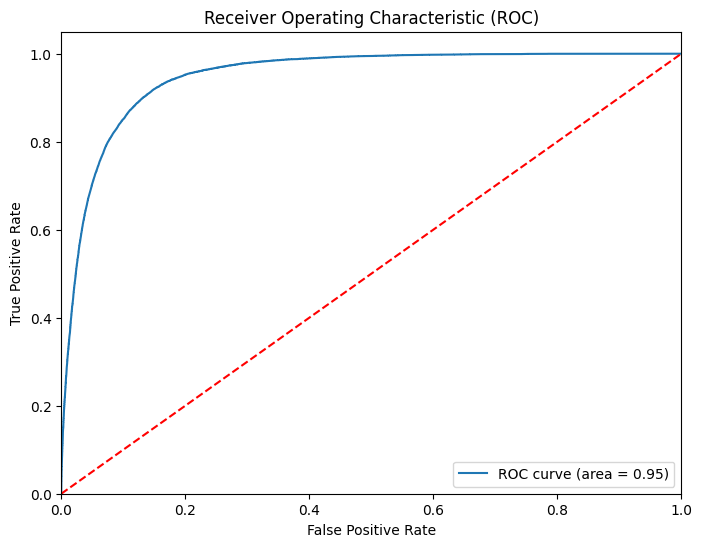

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=12, class_weight = 'balanced')
model.fit(expl_train_up, target_train_up)
target_pred = model.predict(expl_test)


# evaluation metrics
rf_res = []
f1_score = metrics.f1_score(target_test, target_pred)
rf_res.append(f1_score)
accuracy = metrics.accuracy_score(target_test, target_pred)
rf_res.append(accuracy)
recall = metrics.recall_score(target_test, target_pred)
rf_res.append(recall)
precision = metrics.precision_score(target_test, target_pred)
rf_res.append(precision)
balanced_acc = balanced_accuracy_score(target_test, target_pred)
rf_res.append(balanced_acc)
target_probs = model.predict_proba(expl_test)[:, 1]
auc_roc = roc_auc_score(target_test, target_probs)
rf_res.append(auc_roc)


print('***RESULTS ON TEST SET***')
print("F1_score: ",metrics.f1_score(target_test, target_pred))
print("Accuracy",metrics.accuracy_score(target_test, target_pred))
print("Recall",metrics.recall_score(target_test, target_pred))
print("Precision: ", metrics.precision_score(target_test, target_pred)) # tp / (tp + fp)

balanced_acc = balanced_accuracy_score(target_test, target_pred)
print(balanced_acc)


target_probs = model.predict_proba(expl_test)[:, 1]
auc_roc = roc_auc_score(target_test, target_probs)
print(f"AUC-ROC Score: {auc_roc}\n")

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(target_test, target_probs)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

[[90130  5737]
 [ 4717 13864]]


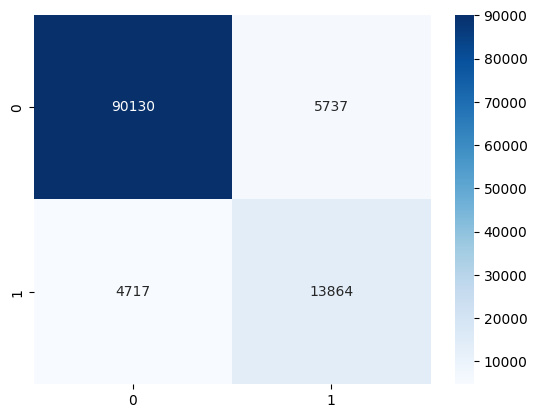

In [ ]:

print(confusion_matrix(target_test, target_pred))

sns.heatmap(confusion_matrix(target_test, target_pred), annot=True, fmt='d', cmap="Blues");

In [ ]:
# save metrics in dictionaries
rf_res_dict = {}
rf_res_dict['model'] = 'SVC'
for name, score in zip(fieldnames, rf_res):
  rf_res_dict[name] = score


In [ ]:
#  This is a helper function we used to save perfomance metric related to different models in a csv file
fieldnames.insert(0, 'model')
for field in fieldnames:
  print(field)
bpath = '/content/drive/MyDrive/MachineLearning'
with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

def compile_csv(model, dict_values):
  # every time we finish training a model, we save in a dict its performance metrics and
  # log them on a csv file
  with open(os.path.join(bpath, 'log.csv'), 'a', newline = '') as csvfile:
    csv_writer = csv.DictWriter(csvfile, dict_values.keys())

    csv_writer.writerow(dict_values)



model
model
f1-score
accuracy
recall
precision
balanced accuracy
auc-roc score


In [ ]:
compile_csv(model, rf_res_dict)

Save results

#**SAVING MODEL**




In [ ]:
import pickle
os.chdir(base_path)
# save the model
with open(f'{base_path}/best_random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Load the model from the saved file
with open('best_random_forest_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

#**PREDICTION ON TEST DATA!**
We created the test dataset just like we did for the training data and we brought it in the PCA domain in order to get the predictions.

In [ ]:
# load test data
os.chdir(test_path)
test_data = []
n = 0
for dir,_, files in os.walk(test_path):
  for file in sorted(files):
    if file.endswith('.csv'):
      filepath = os.path.join(dir, file)
      df = pd.read_csv(filepath)
      #print(filepath)
      n += 1
      obs_idx = int(file.split('.')[0])
      test_parameters_row = test_parameters.loc[obs_idx]
      # now i add to all the rows of the df (i.e. to all the roads) the corresponing training parameters
      # so to all the 191 rows of file '0.csv' i will add the columns with the training parameters
      # of observation 0
      for col in test_parameters_row.index:
        df[col] = test_parameters_row[col]

      # add the edges_info (alt, lat and long)
      df = pd.merge(edges_info, df, on = ['head_id', 'tail_id'],how = 'inner')

        #print(df.columns)
      #print(merged_df.columns)
      test_data.append(df)
print(n)

200


In [ ]:

final_test_data = pd.concat(test_data, ignore_index=True)
# remove all -999 in RainfallIntensity column (they are NA)
final_test_data = final_test_data[final_test_data['RainfallIntensity']!= -999]
print(final_test_data.shape)
print(type(final_test_data))
#final_train_data.loc[191]
final_test_data.head()

(38200, 13)
<class 'pandas.core.frame.DataFrame'>


,head_id,tail_id,longitude,latitude,altitude,Edges_index,flooded_init,SurfaceType,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex
0,151779659,153066427,-95.382821,29.798740,957.0,0,True,D,4,4,0.22,0.28,0
1,151779659,152426116,-95.383237,29.798445,921.2,1,False,D,4,4,0.22,0.28,0
2,151779659,152136099,-95.382354,29.797764,876.0,2,False,D,4,4,0.22,0.28,0
3,151779763,152437059,-95.380082,29.795224,897.0,3,False,D,4,4,0.22,0.28,0
4,151779763,152541741,-95.380394,29.796295,877.6,4,False,D,4,4,0.22,0.28,0


#**Label Encoding**

In [ ]:
label_encoder = LabelEncoder()

final_test_data['FloodedInit'] = label_encoder.fit_transform(final_test_data['flooded_init'])
final_test_data.drop(['flooded_init'], axis = 1, inplace = True)
final_test_data.head()


,head_id,tail_id,longitude,latitude,altitude,Edges_index,SurfaceType,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex,FloodedInit
0,151779659,153066427,-95.382821,29.798740,957.0,0,D,4,4,0.22,0.28,0,1
1,151779659,152426116,-95.383237,29.798445,921.2,1,D,4,4,0.22,0.28,0,0
2,151779659,152136099,-95.382354,29.797764,876.0,2,D,4,4,0.22,0.28,0,0
3,151779763,152437059,-95.380082,29.795224,897.0,3,D,4,4,0.22,0.28,0,0
4,151779763,152541741,-95.380394,29.796295,877.6,4,D,4,4,0.22,0.28,0,0


In [ ]:
final_test_data['SurfaceType_cat'] = label_encoder.fit_transform(final_test_data['SurfaceType'])
final_test_data.drop(['SurfaceType'], axis = 1, inplace = True)
final_test_data.head()

,head_id,tail_id,longitude,latitude,altitude,Edges_index,RainfallIntensity,init_max_hour,DrainageSystemCapacity,GreenSpaceRatio,ObservationIndex,FloodedInit,SurfaceType_cat
0,151779659,153066427,-95.382821,29.798740,957.0,0,4,4,0.22,0.28,0,1,3
1,151779659,152426116,-95.383237,29.798445,921.2,1,4,4,0.22,0.28,0,0,3
2,151779659,152136099,-95.382354,29.797764,876.0,2,4,4,0.22,0.28,0,0,3
3,151779763,152437059,-95.380082,29.795224,897.0,3,4,4,0.22,0.28,0,0,3
4,151779763,152541741,-95.380394,29.796295,877.6,4,4,4,0.22,0.28,0,0,3


In [ ]:
# just a check
print(final_train_data.dtypes)
print(final_train_data.RainfallIntensity.unique())
print(final_train_data.altitude.unique())

head_id                     int64
tail_id                     int64
longitude                 float64
latitude                  float64
altitude                  float64
Edges_index                 int64
RainfallIntensity           int64
init_max_hour               int64
DrainageSystemCapacity    float64
GreenSpaceRatio           float64
ObservationIndex            int64
SurfaceType_cat             int64
FloodedFinal                int64
FloodedInit                 int64
dtype: object
[5 3 4 2]
[-0.29864253 -0.47863248 -0.70588235 -0.60030166 -0.69783811 -0.35847159
 -0.4479638  -0.29562594 -0.74811463 -0.55002514 -0.27249874 -0.17546506
 -0.4826546  -0.5057818  -0.88084465 -0.41779789 -0.31121166 -0.34741076
 -0.45852187 -0.6430367  -0.49120161 -0.79688286 -0.50829563 -0.84313725
 -0.97285068 -0.80844646 -0.81699346 -0.55605832 -0.37355455 -0.2182001
 -0.16540975  0.29713424 -0.93162393 -0.50779286 -0.66013072 -0.12166918
 -0.40472599 -0.1950729  -0.44142785 -0.52941176  0.04022122 -0

#**Standardization**

In [ ]:
#standardization of continuous variables
scaler = MinMaxScaler(feature_range=(-1, 1))
final_test_data[['longitude', 'latitude', 'altitude', "DrainageSystemCapacity", "GreenSpaceRatio"]] = scaler.fit_transform(final_test_data[['longitude', 'latitude', 'altitude', "DrainageSystemCapacity", "GreenSpaceRatio"]])
final_test_data['DrainageSystemCapacity'] = final_test_data['DrainageSystemCapacity']
final_test_data['GreenSpaceRatio'] = final_test_data['GreenSpaceRatio']

#**PCA**

[0.2933363  0.25735173 0.1281509  0.08341936 0.07600427 0.06419761
 0.06292782 0.03074972 0.0038623 ]


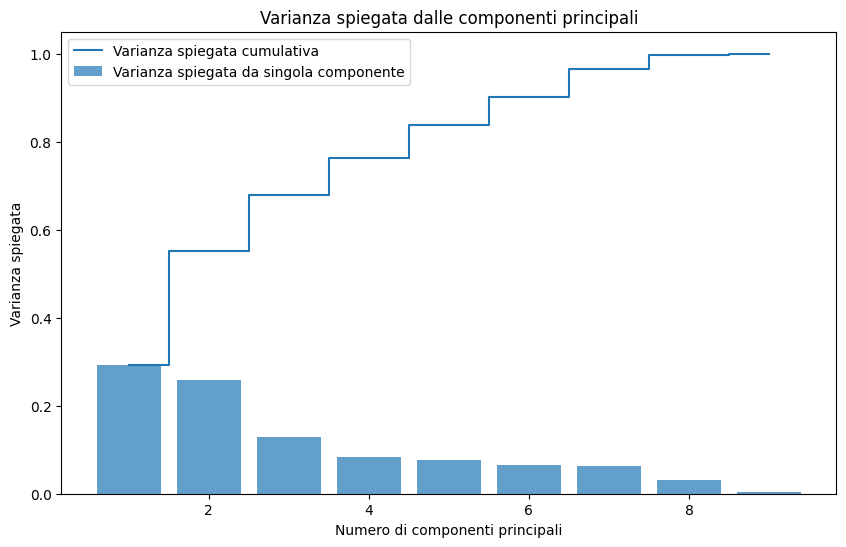

In [ ]:
# evaluation of principal components using PCA
pca_df = final_test_data.drop(['head_id', 'tail_id', 'Edges_index', 'ObservationIndex'], axis = 1)
pca = PCA()
principal_components = pca.fit_transform(pca_df)
explained_variance_ratio = pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)

#graphical representation
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Varianza spiegata da singola componente')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Varianza spiegata cumulativa')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata')
plt.title('Varianza spiegata dalle componenti principali')
plt.legend()
plt.show()


In [ ]:
pca = PCA(n_components = 7)
principal_components = pca.fit_transform(pca_df)
pca_expl_test = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7'])
print(len(pca_expl_test))
pca_expl_train.head()

38200


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,1.186421,-1.773537,1.039603,0.751515,0.895611,-0.841604,-0.529140
1,1.186421,-1.773537,1.039603,0.792160,0.895611,-0.841604,-0.405957
2,1.186421,-1.773537,1.039603,0.566812,0.895611,-0.841604,-0.376377
3,1.186420,-1.773536,1.039603,-0.151065,0.895611,-0.841603,-0.243568
4,1.186421,-1.773536,1.039603,0.045878,0.895611,-0.841603,-0.375500


#**Inference on test data**

In [ ]:
final_test_data = final_test_data.drop(['DrainageSystemCapacity', 'Edges_index', 'FloodedInit', 'GreenSpaceRatio', 'ObservationIndex'], axis = 1)
target_pred = model.predict(pca_expl_test)


#**Save predictions in CSV file**
In the following section we reconstruct the predicted labels and assign them to 'flooded_final' column of each csv file in test directory. 
This reconstruction ensured that each of the 38,200 predictions was correctly associated with the 191 rows present in each of the 200 test data files.

In [ ]:
df = pd.DataFrame(target_pred, columns=['pred'])
df.to_csv('/content/drive/MyDrive/MachineLearning/test_predictions.csv')

In [131]:
import glob
csv_folder = '/content/drive/MyDrive/MachineLearning/MLAssignment202324/test/'
file_csv = glob.glob(csv_folder + '*csv')

In [135]:
target_pred_bool = [bool(val) for val in target_pred] 
# this is useful to have predictions in the same format of flooded-init

In [138]:
# save predictions separately for each observation
# attach predicted label to test csv files
save_dir = '/content/drive/MyDrive/MachineLearning/res/'

for i, element in enumerate(sorted(file_csv)):
  temp_df = pd.read_csv(element)
  start = 191*i
  end = (i+1)*191
  temp_df['flooded_final'] = target_pred_bool[start:end]
  temp_df.to_csv(f'{save_dir}/{i}.csv')

